In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib import pyplot as plt

In [2]:
import os
import function_training
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import json

import numpy as np
import tensorflow as tf

from dataLoader import AnyDataset
import function_training
from function_training import confusion_matrix
from config import MLP_model,hyperparameters, args, CNN_model

numBands=100
bands_type="spin up"

import xgboost as xgb

Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
# step 1. prepare dataset
def json2inputlabel(data_json, bands_type="spin up"):
    _bands_type = {"spin up": "spin_up_bands",
                   "spin down": "spin_down_bands",
                   "soc": "soc_bands"}
    data_input_np = np.array(data_json[_bands_type[bands_type]]) # 100 x 400
    # data_input_np = np.array(data_json[_bands_type[bands_type]]).flataten().T # 40000x1
    data_label_np = np.array([data_json["new_label"]])
    # data_label_np = np.array([data_json["layers_num"]])

    return data_input_np, data_label_np


#take data and set batch size here
train_dataset = AnyDataset("list/actual/train_set.txt", json2inputlabel, args["load"]["numClasses"],bands_type, training=True)
test_dataset = AnyDataset("list/actual/test_set.txt", json2inputlabel, args["load"]["numClasses"],bands_type, training=False)
train_loader = tf.data.Dataset.from_tensor_slices((train_dataset.data_inputs, train_dataset.data_labels)).shuffle(train_dataset.len).batch(hyperparameters['batch_size'])
test_loader = tf.data.Dataset.from_tensor_slices((test_dataset.data_inputs,test_dataset.data_labels)).shuffle(test_dataset.len).batch(hyperparameters['batch_size'])


Loading test set: 100%|██████████████████████| 279/279 [00:00<00:00, 926.51it/s]


Metal device set to: Apple M1 Pro


In [4]:
train_loader2 = tf.data.Dataset.from_tensor_slices((train_dataset.data_inputs,train_dataset.data_labels)).shuffle(train_dataset.len).batch(1000)

# model2 = tf.keras.Sequential(MLP_model)

for element, labels in train_loader2:
#     print (element)
#     print (labels)
#     np.maximum([model(element, training=False)])

#     predict = np.argmax(model.predict(element), axis=-1)
#     label = np.array(labels).flatten()
    break

In [5]:
shape = element.numpy().shape
element_flatten2D_train = element.numpy().reshape(shape[0],shape[1]*shape[2])
labels1D_train = labels.numpy().flatten()

dtrain = xgb.DMatrix(element_flatten2D_train, label=labels1D_train)

In [6]:
test_loader2 = tf.data.Dataset.from_tensor_slices((test_dataset.data_inputs,test_dataset.data_labels)).shuffle(test_dataset.len).batch(1000)

# model2 = tf.keras.Sequential(MLP_model)

for element, labels in test_loader2:
#     print (element)
#     print (labels)
#     np.maximum([model(element, training=False)])

#     predict = np.argmax(model.predict(element), axis=-1)
#     label = np.array(labels).flatten()
    break
    
shape = element.numpy().shape
element_flatten2D_test = element.numpy().reshape(shape[0],shape[1]*shape[2])
labels1D_test = labels.numpy().flatten()

dtest = xgb.DMatrix(element_flatten2D_test, label=labels1D_test)

In [7]:
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
###
# advanced: start from a initial base prediction
#
print('start running example to start from a initial prediction')
# specify parameters via map, definition are same as c++ version
param = {'max_depth': 30, 'eta': 0.002, 'lambda':0, 'alpha':0, 'num_class': 5, 'objective':'multi:softmax'}
# train xgboost for 1 round
bst = xgb.train(param, dtrain, 1000, watchlist, early_stopping_rounds=50)
# Note: we need the margin value instead of transformed prediction in
# set_base_margin
# do predict with output_margin=True, will always give you margin values
# before logistic transformation
ptrain = bst.predict(dtrain)
ptest = bst.predict(dtest)

start running example to start from a initial prediction
[14:17:36] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-mlogloss:1.60728	train-mlogloss:1.60573
[1]	eval-mlogloss:1.60509	train-mlogloss:1.60200
[2]	eval-mlogloss:1.60299	train-mlogloss:1.59831
[3]	eval-mlogloss:1.60086	train-mlogloss:1.59462
[4]	eval-mlogloss:1.59878	train-mlogloss:1.59094
[5]	eval-mlogloss:1.59669	train-mlogloss:1.58727
[6]	eval-mlogloss:1.59463	train-mlogloss:1.58362
[7]	eval-mlogloss:1.59248	train-mlogloss:1.57999
[8]	eval-mlogloss:1.59042	train-mlogloss:1.57638
[9]	eval-mlogloss:1.58832	train-mlogloss:1.57279
[10]	eval-mlogloss:1.58631	train-mlogloss:1.56921
[11]	eval-mlogloss:1.58429	train-mlogloss:1.56565
[12]	eval-mlogloss:1.58219	train-mlogl

[156]	eval-mlogloss:1.37229	train-mlogloss:1.14593
[157]	eval-mlogloss:1.37134	train-mlogloss:1.14366
[158]	eval-mlogloss:1.37031	train-mlogloss:1.14139
[159]	eval-mlogloss:1.36932	train-mlogloss:1.13914
[160]	eval-mlogloss:1.36831	train-mlogloss:1.13687
[161]	eval-mlogloss:1.36732	train-mlogloss:1.13460
[162]	eval-mlogloss:1.36637	train-mlogloss:1.13234
[163]	eval-mlogloss:1.36535	train-mlogloss:1.13010
[164]	eval-mlogloss:1.36441	train-mlogloss:1.12786
[165]	eval-mlogloss:1.36343	train-mlogloss:1.12562
[166]	eval-mlogloss:1.36247	train-mlogloss:1.12336
[167]	eval-mlogloss:1.36150	train-mlogloss:1.12114
[168]	eval-mlogloss:1.36053	train-mlogloss:1.11889
[169]	eval-mlogloss:1.35957	train-mlogloss:1.11667
[170]	eval-mlogloss:1.35862	train-mlogloss:1.11448
[171]	eval-mlogloss:1.35771	train-mlogloss:1.11227
[172]	eval-mlogloss:1.35673	train-mlogloss:1.11005
[173]	eval-mlogloss:1.35583	train-mlogloss:1.10787
[174]	eval-mlogloss:1.35495	train-mlogloss:1.10566
[175]	eval-mlogloss:1.35398	tra

[317]	eval-mlogloss:1.23842	train-mlogloss:0.84409
[318]	eval-mlogloss:1.23777	train-mlogloss:0.84254
[319]	eval-mlogloss:1.23711	train-mlogloss:0.84102
[320]	eval-mlogloss:1.23646	train-mlogloss:0.83948
[321]	eval-mlogloss:1.23582	train-mlogloss:0.83795
[322]	eval-mlogloss:1.23521	train-mlogloss:0.83642
[323]	eval-mlogloss:1.23458	train-mlogloss:0.83490
[324]	eval-mlogloss:1.23397	train-mlogloss:0.83338
[325]	eval-mlogloss:1.23337	train-mlogloss:0.83186
[326]	eval-mlogloss:1.23275	train-mlogloss:0.83034
[327]	eval-mlogloss:1.23213	train-mlogloss:0.82883
[328]	eval-mlogloss:1.23150	train-mlogloss:0.82732
[329]	eval-mlogloss:1.23089	train-mlogloss:0.82582
[330]	eval-mlogloss:1.23030	train-mlogloss:0.82433
[331]	eval-mlogloss:1.22969	train-mlogloss:0.82283
[332]	eval-mlogloss:1.22906	train-mlogloss:0.82136
[333]	eval-mlogloss:1.22844	train-mlogloss:0.81987
[334]	eval-mlogloss:1.22780	train-mlogloss:0.81839
[335]	eval-mlogloss:1.22719	train-mlogloss:0.81690
[336]	eval-mlogloss:1.22656	tra

[478]	eval-mlogloss:1.15481	train-mlogloss:0.63682
[479]	eval-mlogloss:1.15438	train-mlogloss:0.63572
[480]	eval-mlogloss:1.15398	train-mlogloss:0.63465
[481]	eval-mlogloss:1.15358	train-mlogloss:0.63357
[482]	eval-mlogloss:1.15319	train-mlogloss:0.63251
[483]	eval-mlogloss:1.15277	train-mlogloss:0.63143
[484]	eval-mlogloss:1.15239	train-mlogloss:0.63036
[485]	eval-mlogloss:1.15200	train-mlogloss:0.62930
[486]	eval-mlogloss:1.15160	train-mlogloss:0.62823
[487]	eval-mlogloss:1.15119	train-mlogloss:0.62717
[488]	eval-mlogloss:1.15081	train-mlogloss:0.62611
[489]	eval-mlogloss:1.15041	train-mlogloss:0.62504
[490]	eval-mlogloss:1.14996	train-mlogloss:0.62398
[491]	eval-mlogloss:1.14956	train-mlogloss:0.62293
[492]	eval-mlogloss:1.14912	train-mlogloss:0.62187
[493]	eval-mlogloss:1.14871	train-mlogloss:0.62082
[494]	eval-mlogloss:1.14826	train-mlogloss:0.61978
[495]	eval-mlogloss:1.14785	train-mlogloss:0.61872
[496]	eval-mlogloss:1.14743	train-mlogloss:0.61768
[497]	eval-mlogloss:1.14705	tra

[639]	eval-mlogloss:1.09286	train-mlogloss:0.48787
[640]	eval-mlogloss:1.09255	train-mlogloss:0.48708
[641]	eval-mlogloss:1.09219	train-mlogloss:0.48629
[642]	eval-mlogloss:1.09184	train-mlogloss:0.48550
[643]	eval-mlogloss:1.09150	train-mlogloss:0.48472
[644]	eval-mlogloss:1.09117	train-mlogloss:0.48393
[645]	eval-mlogloss:1.09085	train-mlogloss:0.48314
[646]	eval-mlogloss:1.09054	train-mlogloss:0.48236
[647]	eval-mlogloss:1.09021	train-mlogloss:0.48157
[648]	eval-mlogloss:1.08988	train-mlogloss:0.48080
[649]	eval-mlogloss:1.08960	train-mlogloss:0.48002
[650]	eval-mlogloss:1.08927	train-mlogloss:0.47924
[651]	eval-mlogloss:1.08898	train-mlogloss:0.47848
[652]	eval-mlogloss:1.08865	train-mlogloss:0.47770
[653]	eval-mlogloss:1.08834	train-mlogloss:0.47694
[654]	eval-mlogloss:1.08805	train-mlogloss:0.47618
[655]	eval-mlogloss:1.08772	train-mlogloss:0.47541
[656]	eval-mlogloss:1.08742	train-mlogloss:0.47466
[657]	eval-mlogloss:1.08710	train-mlogloss:0.47390
[658]	eval-mlogloss:1.08685	tra

[800]	eval-mlogloss:1.05056	train-mlogloss:0.37913
[801]	eval-mlogloss:1.05035	train-mlogloss:0.37855
[802]	eval-mlogloss:1.05009	train-mlogloss:0.37799
[803]	eval-mlogloss:1.04984	train-mlogloss:0.37742
[804]	eval-mlogloss:1.04967	train-mlogloss:0.37685
[805]	eval-mlogloss:1.04943	train-mlogloss:0.37629
[806]	eval-mlogloss:1.04922	train-mlogloss:0.37572
[807]	eval-mlogloss:1.04901	train-mlogloss:0.37515
[808]	eval-mlogloss:1.04876	train-mlogloss:0.37459
[809]	eval-mlogloss:1.04857	train-mlogloss:0.37401
[810]	eval-mlogloss:1.04831	train-mlogloss:0.37345
[811]	eval-mlogloss:1.04805	train-mlogloss:0.37289
[812]	eval-mlogloss:1.04781	train-mlogloss:0.37232
[813]	eval-mlogloss:1.04754	train-mlogloss:0.37176
[814]	eval-mlogloss:1.04730	train-mlogloss:0.37119
[815]	eval-mlogloss:1.04702	train-mlogloss:0.37064
[816]	eval-mlogloss:1.04674	train-mlogloss:0.37008
[817]	eval-mlogloss:1.04652	train-mlogloss:0.36952
[818]	eval-mlogloss:1.04625	train-mlogloss:0.36896
[819]	eval-mlogloss:1.04604	tra

[961]	eval-mlogloss:1.01734	train-mlogloss:0.29881
[962]	eval-mlogloss:1.01722	train-mlogloss:0.29838
[963]	eval-mlogloss:1.01708	train-mlogloss:0.29795
[964]	eval-mlogloss:1.01694	train-mlogloss:0.29753
[965]	eval-mlogloss:1.01685	train-mlogloss:0.29711
[966]	eval-mlogloss:1.01673	train-mlogloss:0.29668
[967]	eval-mlogloss:1.01660	train-mlogloss:0.29626
[968]	eval-mlogloss:1.01650	train-mlogloss:0.29584
[969]	eval-mlogloss:1.01641	train-mlogloss:0.29542
[970]	eval-mlogloss:1.01631	train-mlogloss:0.29500
[971]	eval-mlogloss:1.01619	train-mlogloss:0.29458
[972]	eval-mlogloss:1.01610	train-mlogloss:0.29416
[973]	eval-mlogloss:1.01603	train-mlogloss:0.29375
[974]	eval-mlogloss:1.01597	train-mlogloss:0.29334
[975]	eval-mlogloss:1.01585	train-mlogloss:0.29292
[976]	eval-mlogloss:1.01574	train-mlogloss:0.29251
[977]	eval-mlogloss:1.01564	train-mlogloss:0.29209
[978]	eval-mlogloss:1.01556	train-mlogloss:0.29168
[979]	eval-mlogloss:1.01546	train-mlogloss:0.29127
[980]	eval-mlogloss:1.01537	tra

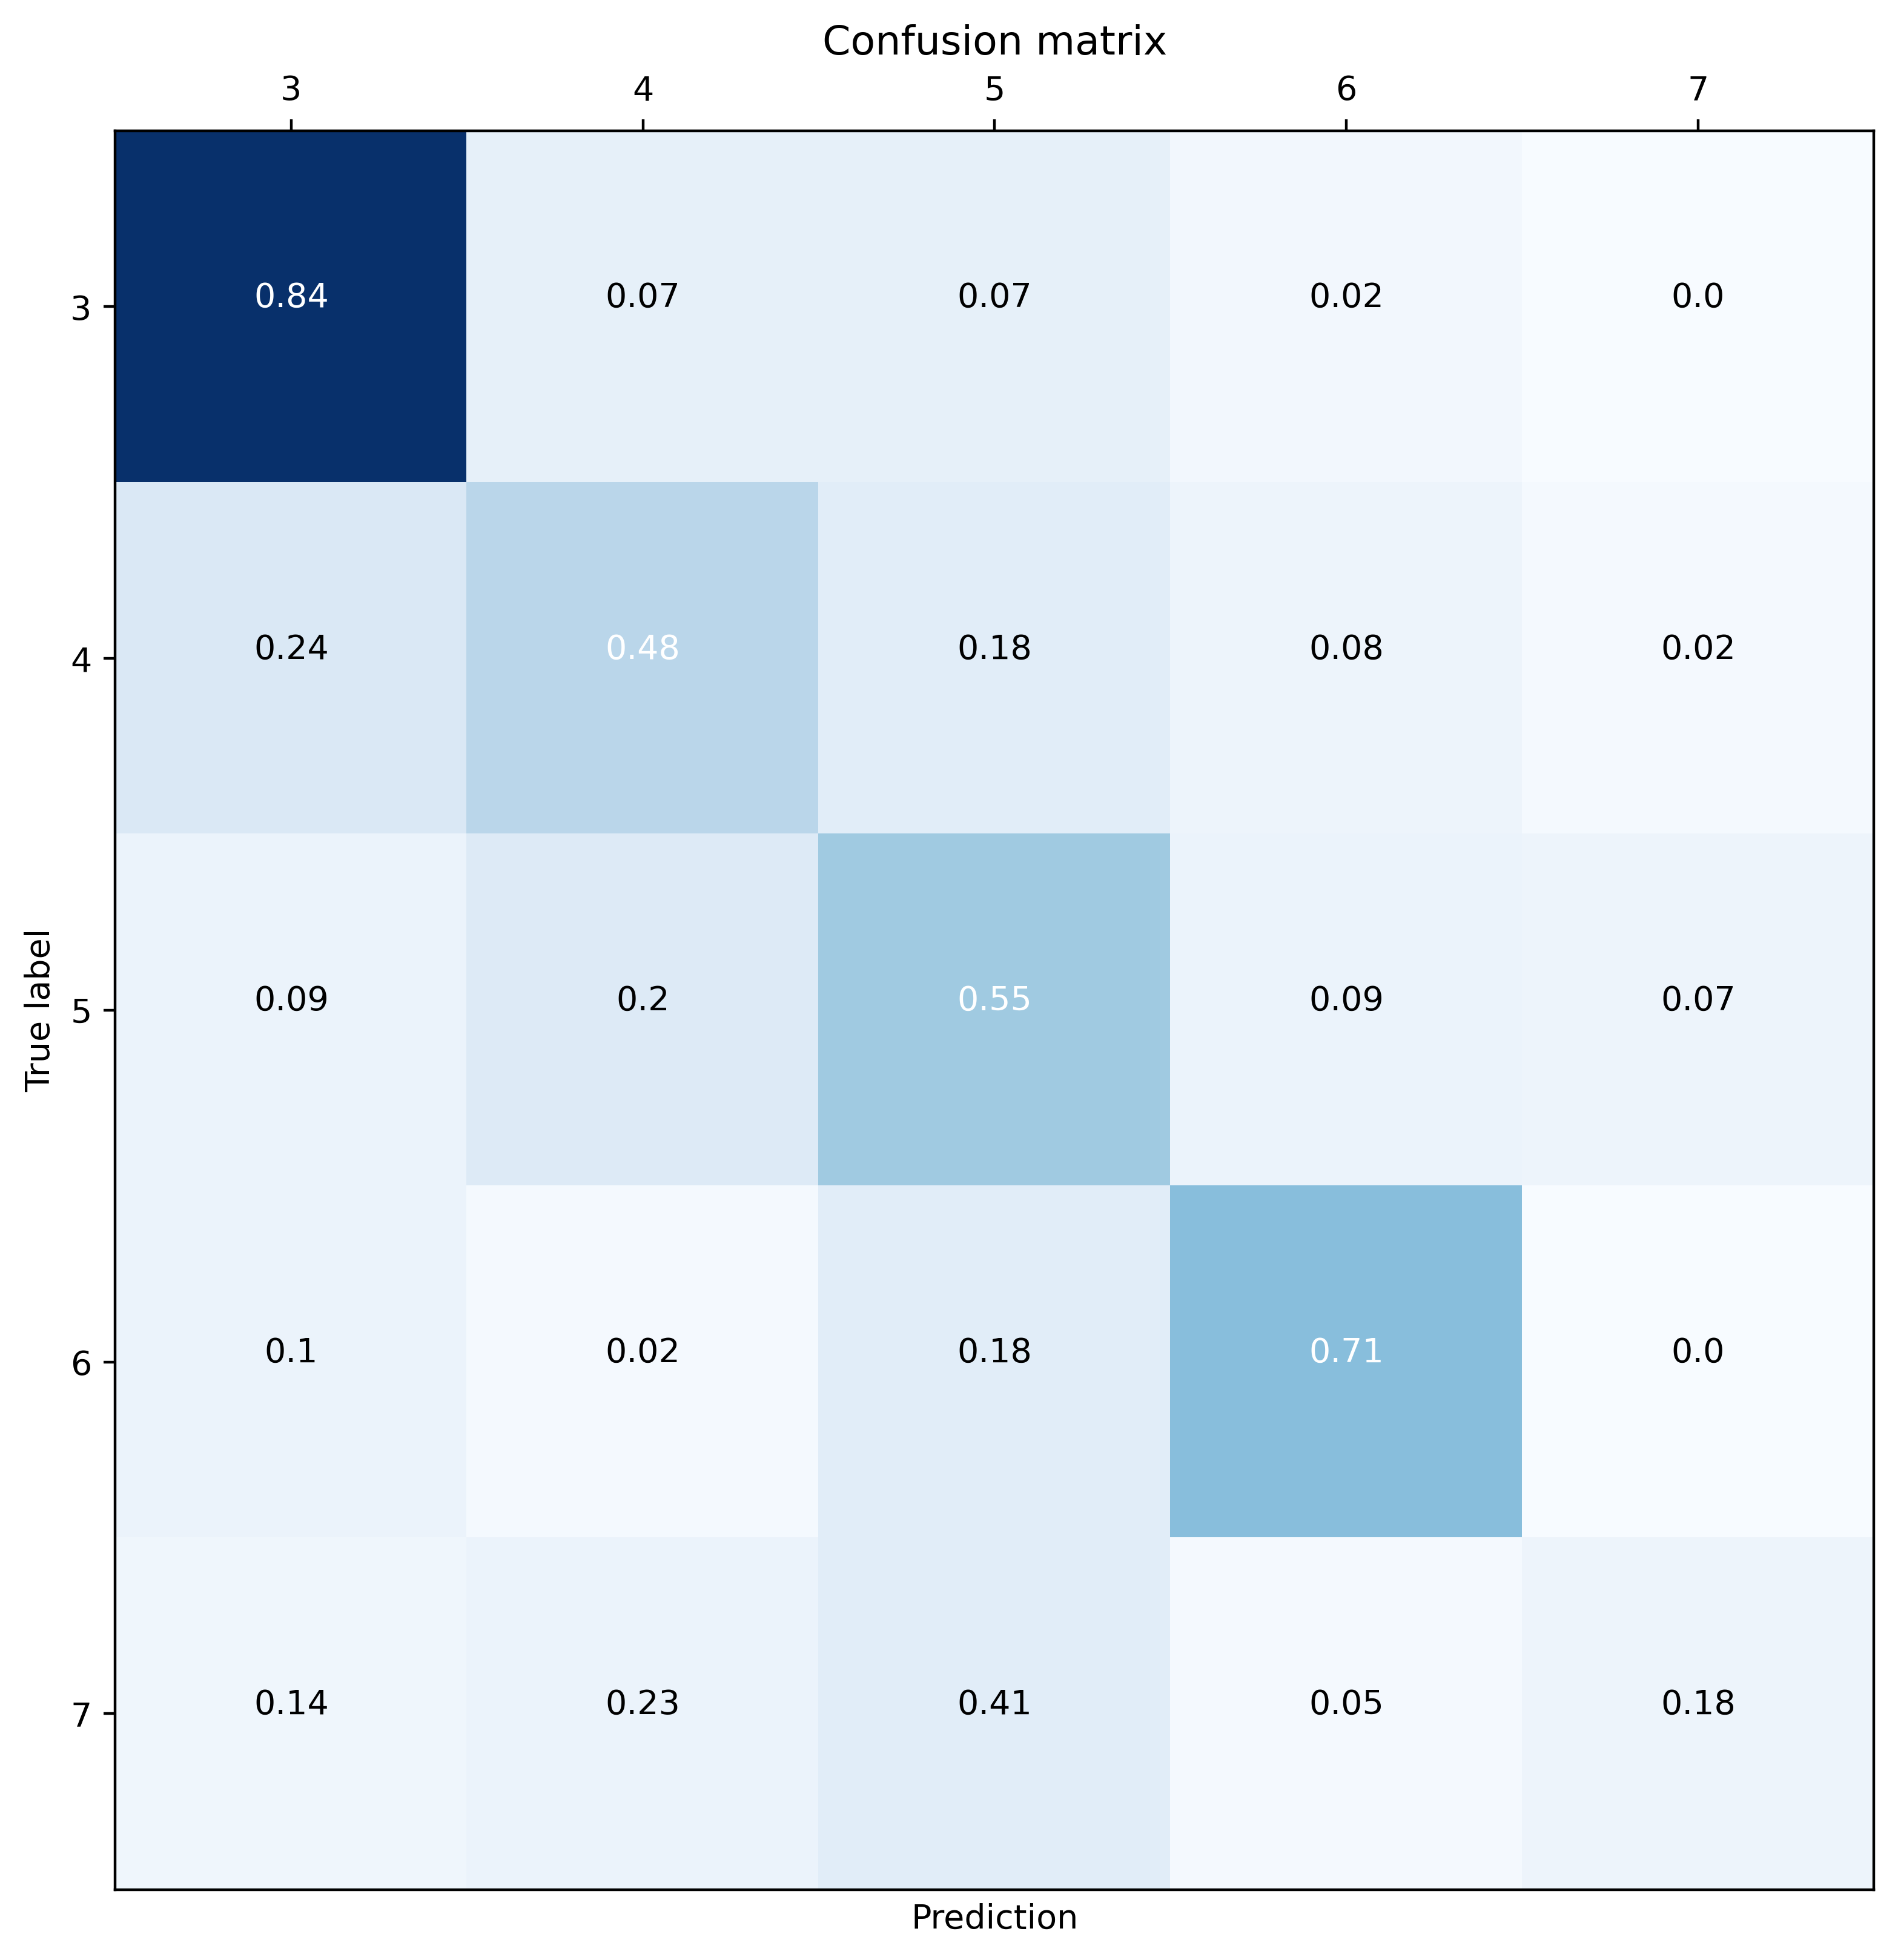

In [8]:
confusion_matrix(labels=labels1D_test, predictions=ptest, class_names=[3, 4, 5, 6, 7])

In [9]:
# m = tf.keras.metrics.SparseCategoricalAccuracy()
# m.update_state(labels1D_test.reshape(1,100).shape, ptest.reshape(1,100).shape)
# m.result().numpy()

In [10]:
from sklearn.metrics import accuracy_score
mse = accuracy_score(y_true=labels1D_test, y_pred=ptest)
mse
# test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
# print (test_accuracy(labels1D_test.reshape(labels1D_test.shape[0],1), ptest.reshape(ptest.shape[0],1)))

0.6415770609318996

<Figure size 32000x20000 with 0 Axes>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 32000x20000 with 0 Axes>

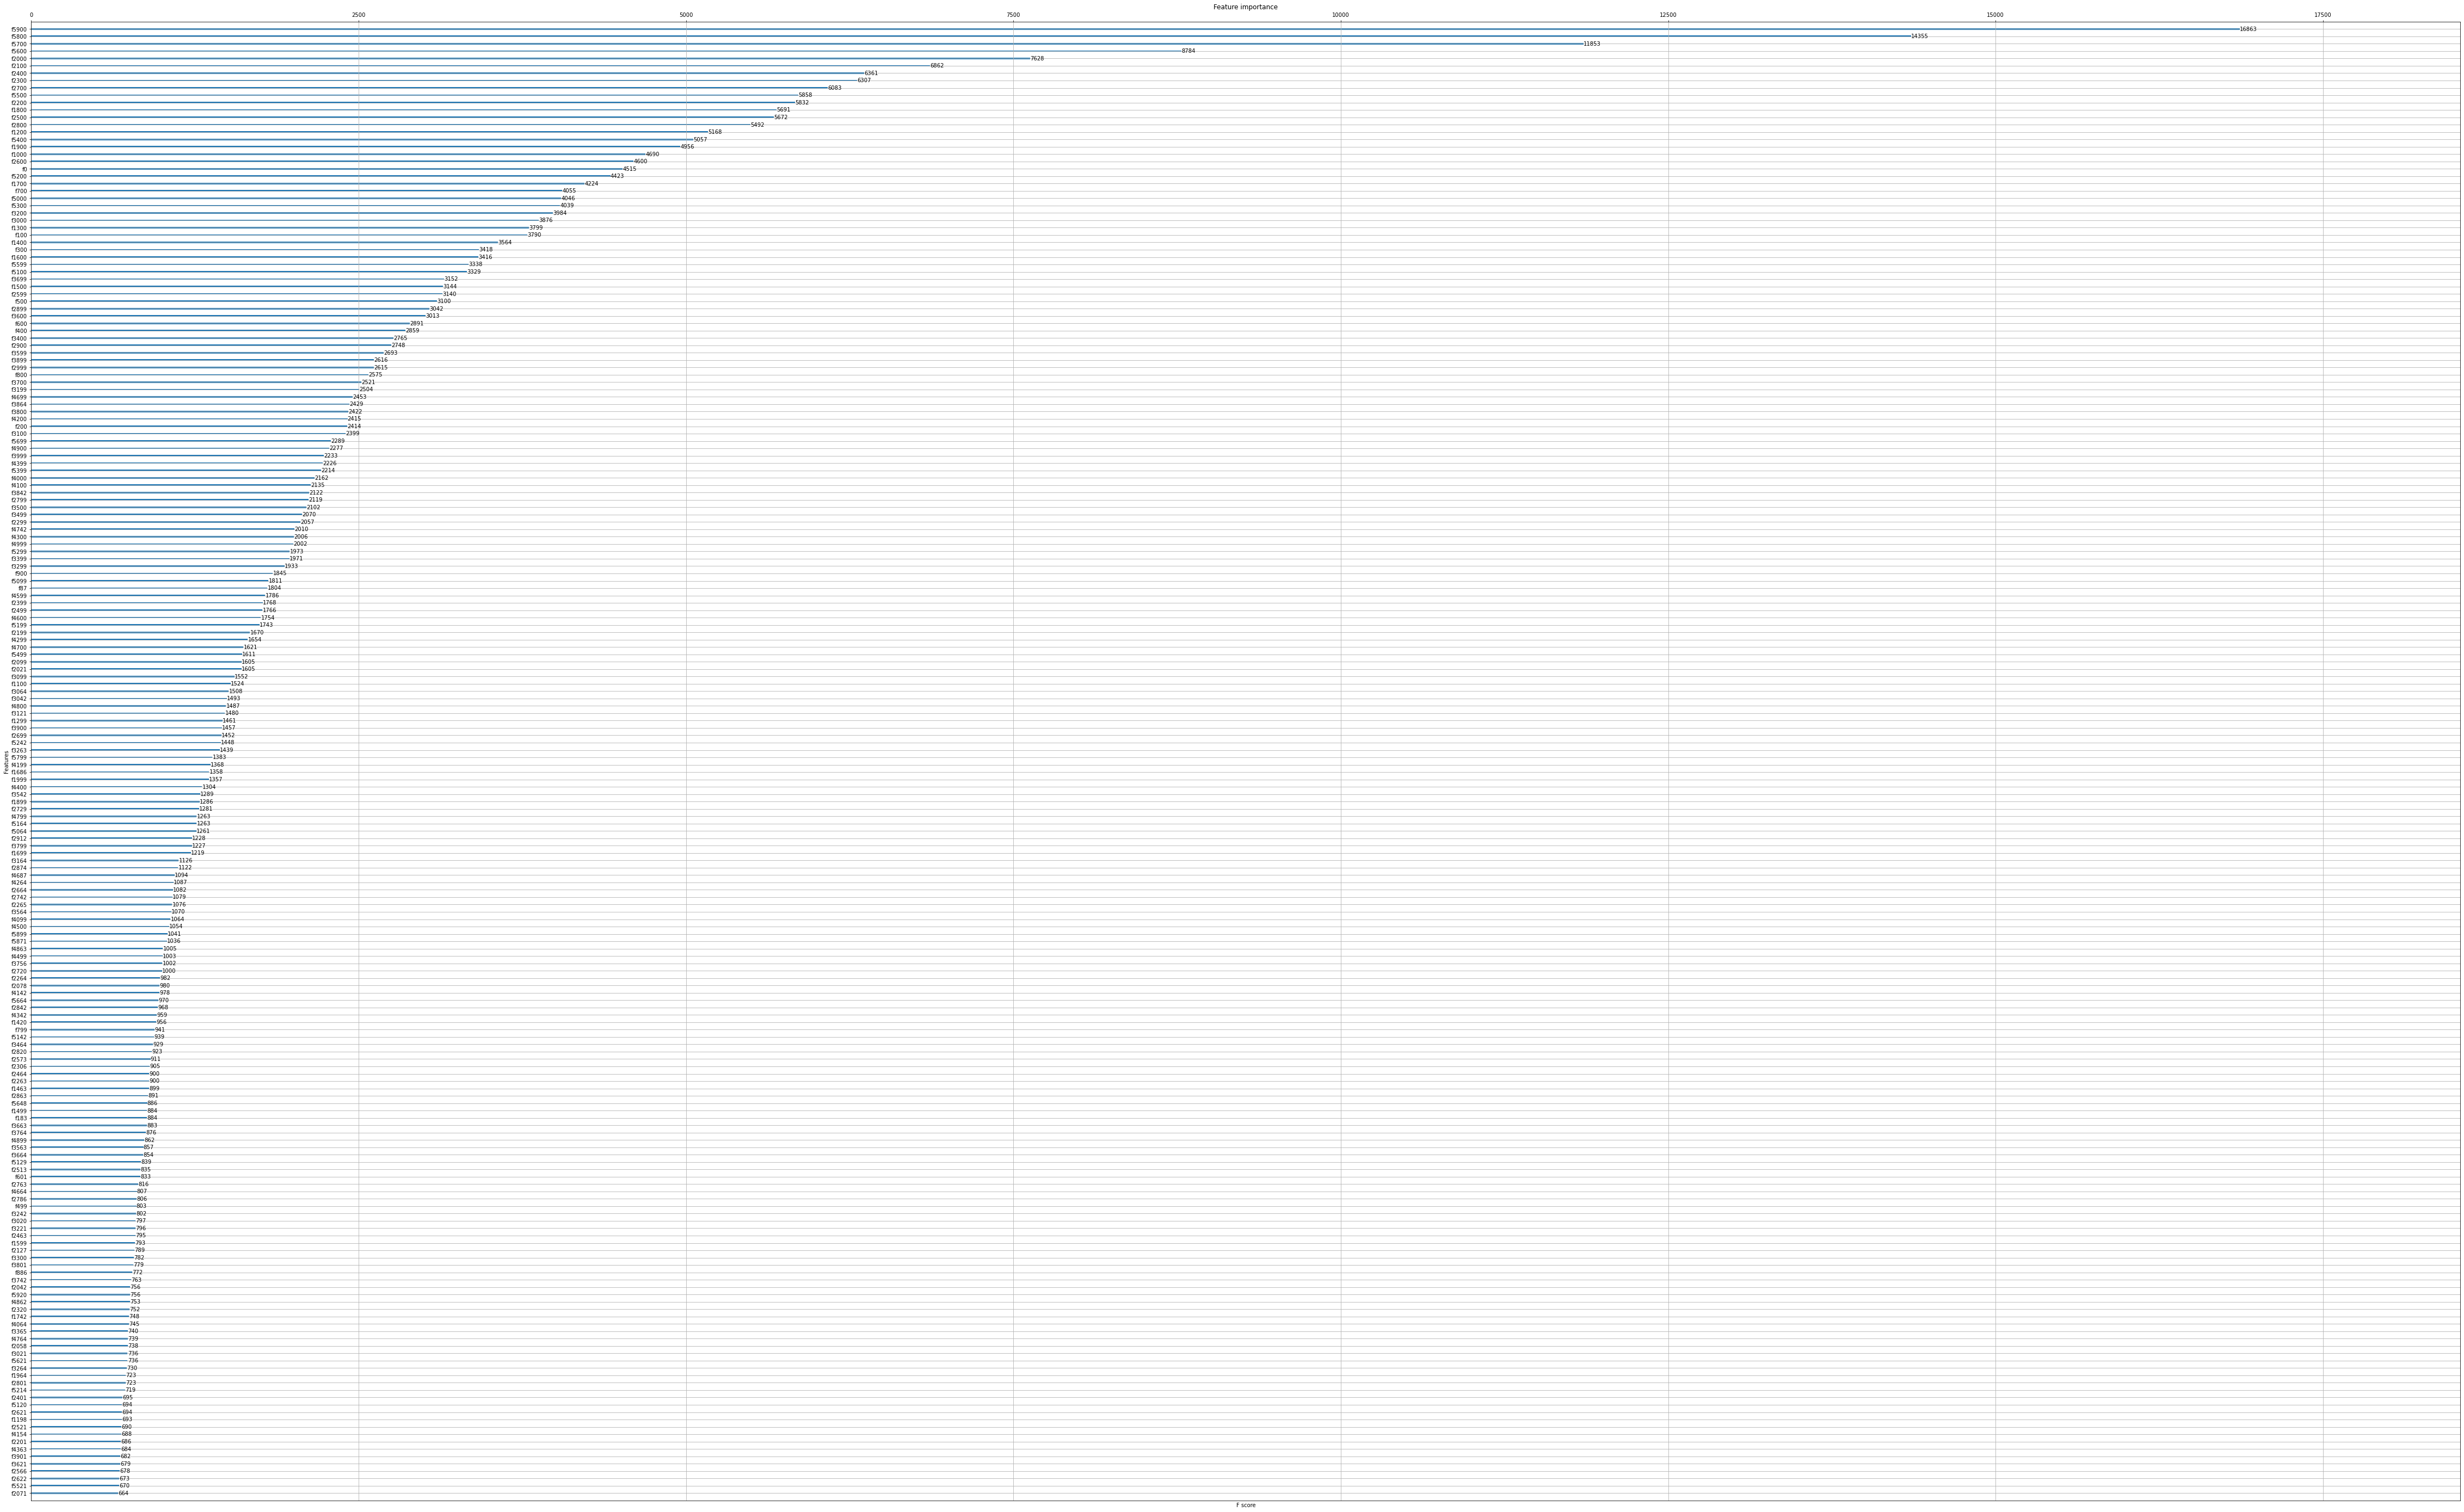

In [11]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 80,50
plt.figure(dpi=400)
xgb.plot_importance(bst, max_num_features=200)

<Figure size 32000x20000 with 0 Axes>

<AxesSubplot:>

<Figure size 32000x20000 with 0 Axes>

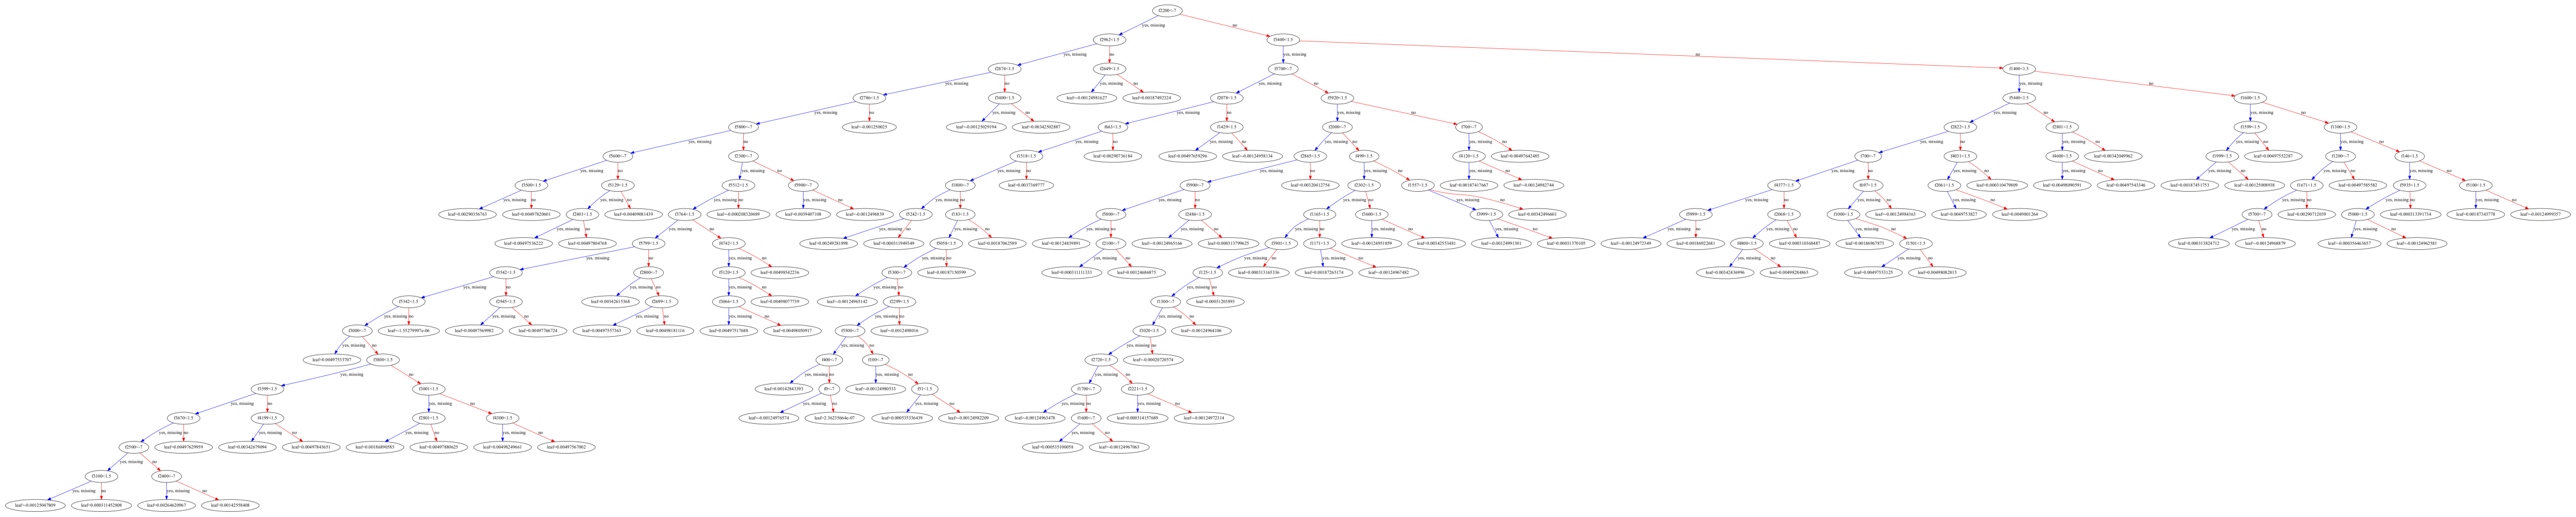

In [12]:
from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 80,50
plt.figure(figsize=(80, 50), dpi=400)
xgb.plot_tree(bst, num_trees=5)

In [13]:
results = bst.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

AttributeError: 'Booster' object has no attribute 'evals_result'